In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
import sys
sys.path.append('../code')
from gplar import GPLARegressor

In [2]:
N = 50
x = np.linspace(0.0,1.0,N).reshape(N,1)

f1 = lambda x: -np.sin(10*np.pi*(x+1))/(2*x+1)-x**4
h1 = lambda x: f1(x) + np.random.normal(0,1e-5)
y1 = np.array(list(map(h1,x))) + np.random.normal(0,0.05,N).reshape(N,1)

f2 = lambda x: np.cos(h1(x))**2 + np.sin(3*x)
h2 = lambda x: f2(x) + np.random.normal(0,1e-5)
y2 = np.array(list(map(h2,x))) + np.random.normal(0,0.05,N).reshape(N,1)

f3 = lambda x: h2(x)*h1(x)**2 + 3*x
h3 = lambda x: f3(x) + np.random.normal(0,1e-5)
y3 = np.array(list(map(h3,x))) + np.random.normal(0,0.05,N).reshape(N,1)

In [73]:
# Randomly remove some first/second output
mask_1 = np.random.choice([True,False],size=N,p=[0.3,0.7])
mask_2 = np.random.choice([True,False],size=N,p=[0.3,0.7])

In [3]:
mask_1_continuous = np.array([False]*10 + [True]*10 + [False]*30)
mask_2_continuous = np.array([False]*30 + [True]*10 + [False]*10)

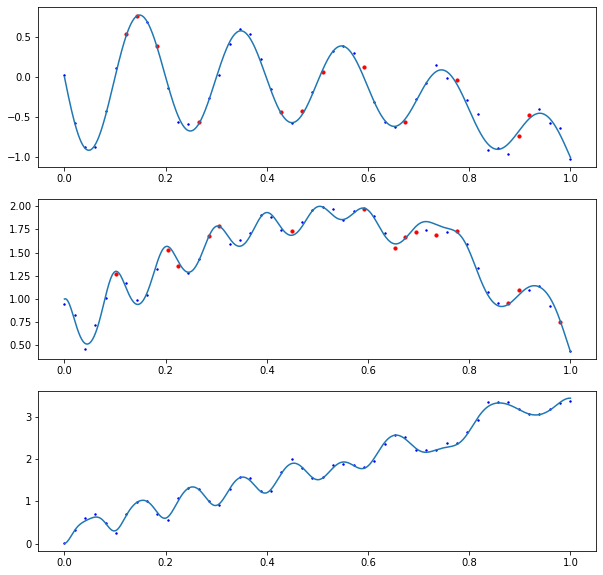

In [35]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x[~mask_1],y1[~mask_1], s=2, c='blue')
ax1.scatter(x[mask_1],y1[mask_1], s=10, c='red')
x_ = np.linspace(0.0,1.0,1000)
h1_ = np.array(list(map(f1,x_)))
ax1.plot(x_,h1_)

ax2.scatter(x[~mask_2],y2[~mask_2], s=2, c='blue')
ax2.scatter(x[mask_2],y2[mask_2], s=10, c='red')
f2_ = lambda x: np.cos(f1(x))**2 + np.sin(3*x)
h2_ = np.array(list(map(f2_,x_)))
ax2.plot(x_,h2_)

ax3.scatter(x,y3, s=2, c='blue')
f3_ = lambda x: f2_(x)*f1(x)**2 + 3*x
h3_ = np.array(list(map(f3_,x_)))
ax3.plot(x_,h3_)

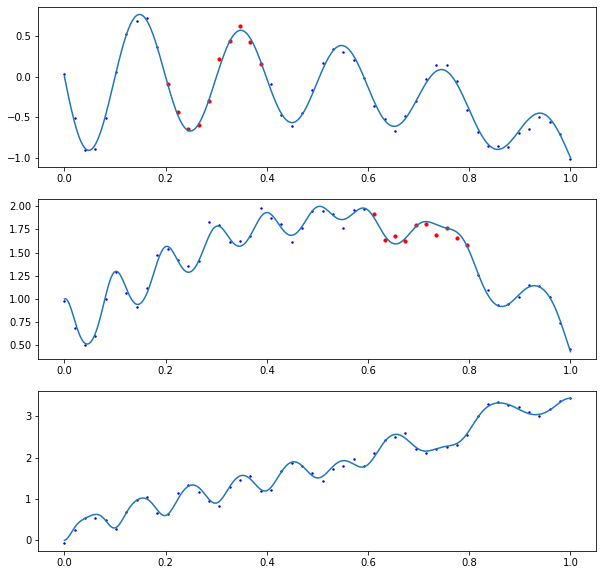

In [14]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x[~mask_1_continuous],y1[~mask_1_continuous], s=2, c='blue')
ax1.scatter(x[mask_1_continuous],y1[mask_1_continuous], s=10, c='red')
x_ = np.linspace(0.0,1.0,1000)
h1_ = np.array(list(map(f1,x_)))
ax1.plot(x_,h1_)

ax2.scatter(x[~mask_2_continuous],y2[~mask_2_continuous], s=2, c='blue')
ax2.scatter(x[mask_2_continuous],y2[mask_2_continuous], s=10, c='red')
f2_ = lambda x: np.cos(f1(x))**2 + np.sin(3*x)
h2_ = np.array(list(map(f2_,x_)))
ax2.plot(x_,h2_)

ax3.scatter(x,y3, s=2, c='blue')
f3_ = lambda x: f2_(x)*f1(x)**2 + 3*x
h3_ = np.array(list(map(f3_,x_)))
ax3.plot(x_,h3_)

In [74]:
y1_miss, y2_miss = y1.copy(), y2.copy()
y1_miss[mask_1]=None
y2_miss[mask_2]=None
y_obs = np.concatenate((y1_miss,y2_miss,y3),axis=-1)

In [35]:
y1_miss_c, y2_miss_c = y1.copy(), y2.copy()
y1_miss_c[mask_1_continuous]=None
y2_miss_c[mask_2_continuous]=None
y_obs_c = np.concatenate((y1_miss_c,y2_miss_c,y3),axis=-1)

In [75]:
M = 20 # number of inducing points
m = GPLARegressor(x, y_obs, M, white=False,
                 scale=0.1,
                 linear=True, linear_scale=10.0,
                 nonlinear=True, nonlinear_scale=0.1,
                 noise_inner=1e-5, noise_obs=0.05,
                 num_samples=100)

In [36]:
M=20
m_c = GPLARegressor(x, y_obs_c, M, white=False,
                 scale=0.1,
                 linear=True, linear_scale=10.0,
                 nonlinear=True, nonlinear_scale=0.1,
                 noise_inner=1e-5, noise_obs=0.05,
                 num_samples=100)

In [77]:
@tf.function(autograph=False)
def optimization_step(optimizer, model, data):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = -model.maximum_log_likelihood_objective(*data)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, data, iterations):
    logf=[]
    adam = tf.optimizers.Adam(0.01)
    for step in range(iterations):
        neg_elbo = optimization_step(adam, model, data)
        elbo = -neg_elbo
        if step%10 == 0:
            logf.append(elbo.numpy())
        if step%500 == 0:
            print(elbo.numpy())
    return logf

In [ ]:
from gpflow.ci_utils import ci_niter
maxiter = ci_niter(3000)
logf = run_adam(m, (x,y_obs), maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of GPLAR')

-1330.2226236777956
-24.081075639874463
29.8019286425629
40.49085146838435


-2222.5840188834923
-42.98368890861441
-15.254819608311934
-6.905834473954684
-13.564250948090105
21.067336652042997
2.541768000959493
28.41045581259627
23.864719023277914
28.390641996962103


Text(0.5, 1.0, 'ELBO of GPLAR continuous missing')

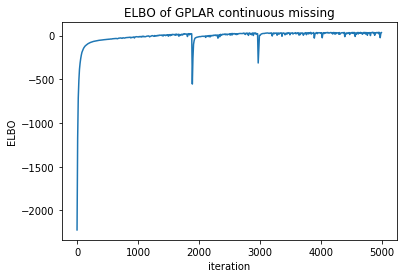

In [38]:
from gpflow.ci_utils import ci_niter
maxiter = ci_niter(5000)
logf = run_adam(m_c, (x,y_obs_c), maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of GPLAR continuous missing')

In [50]:
x__ = np.linspace(0.0,1.0,1000).reshape(1000,1)
Hmeans, Hvars = m.predict_f(x__, 100)

In [51]:
Hmeans_c, Hvars_c = m_c.predict_f(x__, 100)

In [32]:
def getMeanandBound(Hmeans,Hvars):
    result = []
    for i in range(len(Hmeans)):
        mean = tf.reduce_mean(Hmeans[i],axis=0)
        sd = tf.sqrt(tf.reduce_mean(Hvars[i],axis=0))
        
        result.append([mean,mean+2.24*sd, mean-2.24*sd])
        
    return result

predict_y = getMeanandBound(Hmeans, Hvars)

In [52]:
predict_y_c = getMeanandBound(Hmeans_c, Hvars_c)

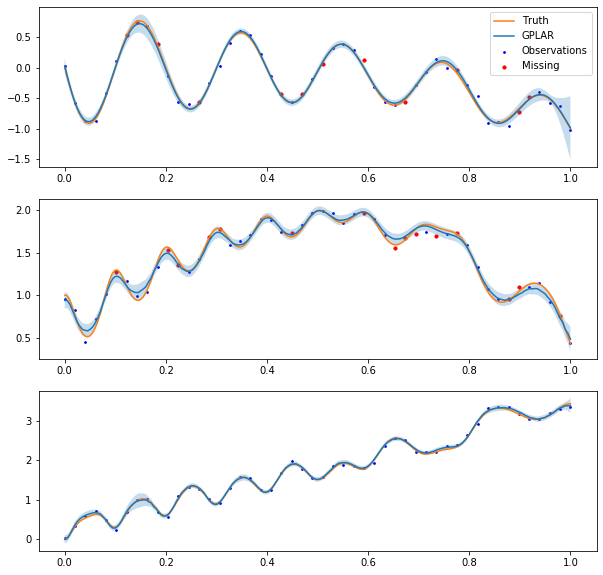

In [54]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x[~mask_1],y1[~mask_1], s=3, label='Observations',c='blue')
ax1.scatter(x[mask_1],y1[mask_1],label='Missing', s=10, c='red')
ax1.plot(x_,h1_,label='Truth',c='tab:orange')
ax1.plot(x__,predict_y[0][0], label='GPLAR', c='tab:blue')
ax1.fill_between(x__[:,0],predict_y[0][2][:,0], predict_y[0][1][:,0],
                facecolor='tab:blue', alpha=.25)
ax1.legend()

ax2.scatter(x[~mask_2],y2[~mask_2], s=3, c='blue')
ax2.scatter(x[mask_2],y2[mask_2], s=10, c='red')
ax2.plot(x_,h2_,label='Truth',c='tab:orange')
ax2.plot(x__,predict_y[1][0], label='GPLAR', c='tab:blue')
ax2.fill_between(x__[:,0],predict_y[1][2][:,0], predict_y[1][1][:,0],
                facecolor='tab:blue', alpha=.25)

ax3.scatter(x,y_obs[:,2:],s=3,label='Observations',c='blue')
ax3.plot(x_,h3_,label='Truth',c='tab:orange')
ax3.plot(x__,predict_y[2][0], label='GPLAR', c='tab:blue')
ax3.fill_between(x__[:,0],predict_y[2][2][:,0], predict_y[2][1][:,0],
                facecolor='tab:blue', alpha=.25)


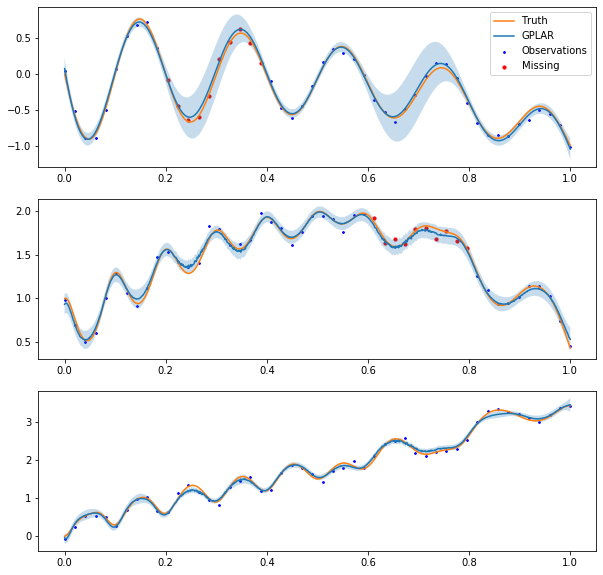

In [53]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x[~mask_1_continuous],y1[~mask_1_continuous], s=3, label='Observations',c='blue')
ax1.scatter(x[mask_1_continuous],y1[mask_1_continuous],label='Missing', s=10, c='red')
ax1.plot(x_,h1_,label='Truth',c='tab:orange')
ax1.plot(x__,predict_y_c[0][0], label='GPLAR', c='tab:blue')
ax1.fill_between(x__[:,0],predict_y_c[0][2][:,0], predict_y_c[0][1][:,0],
                facecolor='tab:blue', alpha=.25)
ax1.legend()

ax2.scatter(x[~mask_2_continuous],y2[~mask_2_continuous], s=3, c='blue')
ax2.scatter(x[mask_2_continuous],y2[mask_2_continuous], s=10, c='red')
ax2.plot(x_,h2_,label='Truth',c='tab:orange')
ax2.plot(x__,predict_y_c[1][0], label='GPLAR', c='tab:blue')
ax2.fill_between(x__[:,0],predict_y_c[1][2][:,0], predict_y_c[1][1][:,0],
                facecolor='tab:blue', alpha=.25)

ax3.scatter(x,y3,s=3,label='Observations',c='blue')
ax3.plot(x_,h3_,label='Truth',c='tab:orange')
ax3.plot(x__,predict_y_c[2][0], label='GPLAR', c='tab:blue')
ax3.fill_between(x__[:,0],predict_y_c[2][2][:,0], predict_y_c[2][1][:,0],
                facecolor='tab:blue', alpha=.25)

In [17]:
from gpar.regression import GPARRegressor

In [48]:
model = GPARRegressor(scale=0.1,
                      linear=True, linear_scale=10.,
                      nonlinear=True, nonlinear_scale=0.1,
                      noise=0.1,
                      impute=True, replace=True, normalise_y=False)
model.fit(x,y_obs)

Training conditionals (total: 3): 1 2 3


In [18]:
model_c = GPARRegressor(scale=0.1,
                      linear=True, linear_scale=10.,
                      nonlinear=True, nonlinear_scale=0.1,
                      noise=0.1,
                      impute=True, replace=True, normalise_y=False)
model_c.fit(x,y_obs_c)

Training conditionals (total: 3): 1 2 3


In [49]:
means, lowers, uppers = \
    model.predict(x__, num_samples=200, credible_bounds=True, latent=True)

Sampling (total: 200): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200


In [54]:
means_c, lowers_c, uppers_c = \
    model_c.predict(x__, num_samples=200, credible_bounds=True, latent=True)

Sampling (total: 200): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200


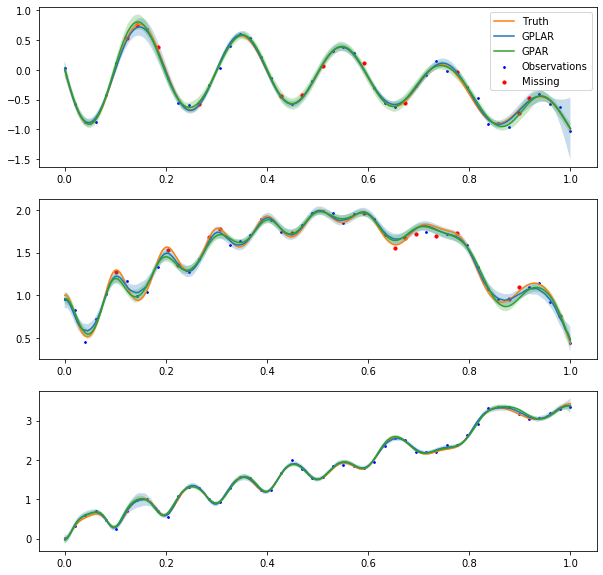

In [58]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x[~mask_1],y1[~mask_1], s=3, label='Observations',c='blue')
ax1.plot(x_,h1_,label='Truth',c='tab:orange')
ax1.plot(x__,predict_y[0][0], label='GPLAR', c='tab:blue')
ax1.fill_between(x__[:,0],predict_y[0][2][:,0], predict_y[0][1][:,0],
                facecolor='tab:blue', alpha=.25)
ax1.plot(x__,means[:,0], label='GPAR', c='tab:green')
ax1.fill_between(x__[:,0],lowers[:,0], uppers[:,0],
                facecolor='tab:green', alpha=.25)
ax1.scatter(x[mask_1],y1[mask_1],label='Missing', s=10, c='red')
ax1.legend()

ax2.scatter(x[~mask_2],y2[~mask_2], s=3, c='blue')
ax2.scatter(x[mask_2],y2[mask_2], s=10, c='red')
ax2.plot(x_,h2_,label='Truth',c='tab:orange')
ax2.plot(x__,predict_y[1][0], label='GPLAR', c='tab:blue')
ax2.fill_between(x__[:,0],predict_y[1][2][:,0], predict_y[1][1][:,0],
                facecolor='tab:blue', alpha=.25)
ax2.plot(x__,means[:,1], label='GPAR', c='tab:green')
ax2.fill_between(x__[:,0],lowers[:,1], uppers[:,1],
                facecolor='tab:green', alpha=.25)

ax3.scatter(x,y_obs[:,2:],s=3,label='Observations',c='blue')
ax3.plot(x_,h3_,label='Truth',c='tab:orange')
ax3.plot(x__,predict_y[2][0], label='GPLAR', c='tab:blue')
ax3.fill_between(x__[:,0],predict_y[2][2][:,0], predict_y[2][1][:,0],
                facecolor='tab:blue', alpha=.25)
ax3.plot(x__,means[:,2], label='GPAR', c='tab:green')
ax3.fill_between(x__[:,0],lowers[:,2], uppers[:,2],
                facecolor='tab:green', alpha=.25)
f.savefig('missing.png',dpi=300)

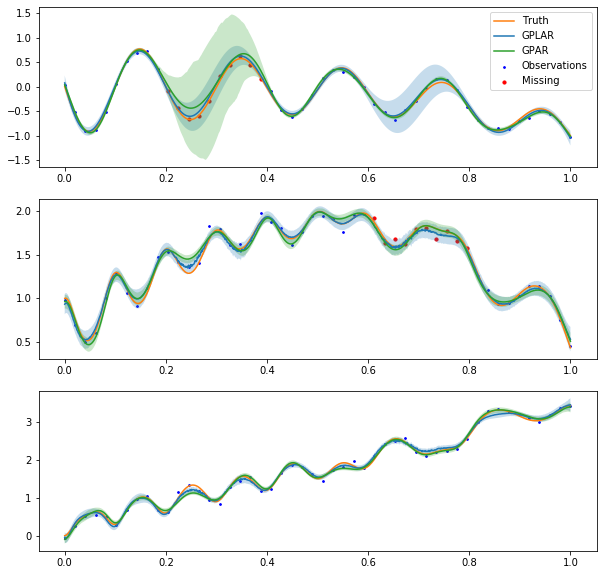

In [55]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x[~mask_1_continuous],y1[~mask_1_continuous], s=3, label='Observations',c='blue')
ax1.scatter(x[mask_1_continuous],y1[mask_1_continuous],label='Missing', s=10, c='red')
ax1.plot(x_,h1_,label='Truth',c='tab:orange')
ax1.plot(x__,predict_y_c[0][0], label='GPLAR', c='tab:blue')
ax1.fill_between(x__[:,0],predict_y_c[0][2][:,0], predict_y_c[0][1][:,0],
                facecolor='tab:blue', alpha=.25)
ax1.plot(x__,means_c[:,0], label='GPAR', c='tab:green')
ax1.fill_between(x__[:,0],lowers_c[:,0], uppers_c[:,0],
                facecolor='tab:green', alpha=.25)
ax1.legend()

ax2.scatter(x[~mask_2_continuous],y2[~mask_2_continuous], s=3, c='blue')
ax2.scatter(x[mask_2_continuous],y2[mask_2_continuous], s=10, c='red')
ax2.plot(x_,h2_,label='Truth',c='tab:orange')
ax2.plot(x__,predict_y_c[1][0], label='GPLAR', c='tab:blue')
ax2.fill_between(x__[:,0],predict_y_c[1][2][:,0], predict_y_c[1][1][:,0],
                facecolor='tab:blue', alpha=.25)
ax2.plot(x__,means_c[:,1], label='GPAR', c='tab:green')
ax2.fill_between(x__[:,0],lowers_c[:,1], uppers_c[:,1],
                facecolor='tab:green', alpha=.25)

ax3.scatter(x,y3,s=3,label='Observations',c='blue')
ax3.plot(x_,h3_,label='Truth',c='tab:orange')
ax3.plot(x__,predict_y_c[2][0], label='GPLAR', c='tab:blue')
ax3.fill_between(x__[:,0],predict_y_c[2][2][:,0], predict_y_c[2][1][:,0],
                facecolor='tab:blue', alpha=.25)
ax3.plot(x__,means_c[:,2], label='GPAR', c='tab:green')
ax3.fill_between(x__[:,0],lowers_c[:,2], uppers_c[:,2],
                facecolor='tab:green', alpha=.25)
f.savefig('missing_c.png',dpi=300)

In [64]:
print('GPLAR:')
print('sum of square y1',(tf.reduce_sum((h1_[:,None]-predict_y_c[0][0])**2).numpy()))
print('sum of square y2',(tf.reduce_sum((h2_[:,None]-predict_y_c[1][0])**2).numpy()))
print('sum of square y3',(tf.reduce_sum((h3_[:,None]-predict_y_c[2][0])**2).numpy()))

GPLAR:
sum of square y1 1.5037560908225094
sum of square y2 1.0100072965476987
sum of square y3 2.5834717988389206


In [71]:
print('GPAR')
print('sum of square y1',np.sum((h1_-means_c[:,0])**2))
print('sum of square y2',np.sum((h2_-means_c[:,1])**2))
print('sum of square y3',np.sum((h3_-means_c[:,2])**2))

GPAR
sum of square y1 5.8382314615145265
sum of square y2 2.373958696199262
sum of square y3 3.78278950565461
